QUADRATIC CHIRP的播放

In [1]:
import numpy as np
import sounddevice as sd  # pip install sounddevice

def func(t, A=1.0, a1=20, a2=10, a3=10):
    return A * np.sin(2 * np.pi * (a1 * t + a2 * t**2 + a3 * t**3))

# 采样参数
duration = 5.0       # 播放时长，单位秒
fs = 44100           # 采样率，单位Hz

t = np.linspace(0, duration, int(fs*duration), endpoint=False)

signal = func(t)

# 确保信号在[-1, 1]范围内
signal = signal / np.max(np.abs(signal))

# 播放声音
sd.play(signal, fs)
sd.wait()  # 等待播放结束


ModuleNotFoundError: No module named 'sounddevice'

对QUADRATIC CHIRP信号的频谱分析和时频分析

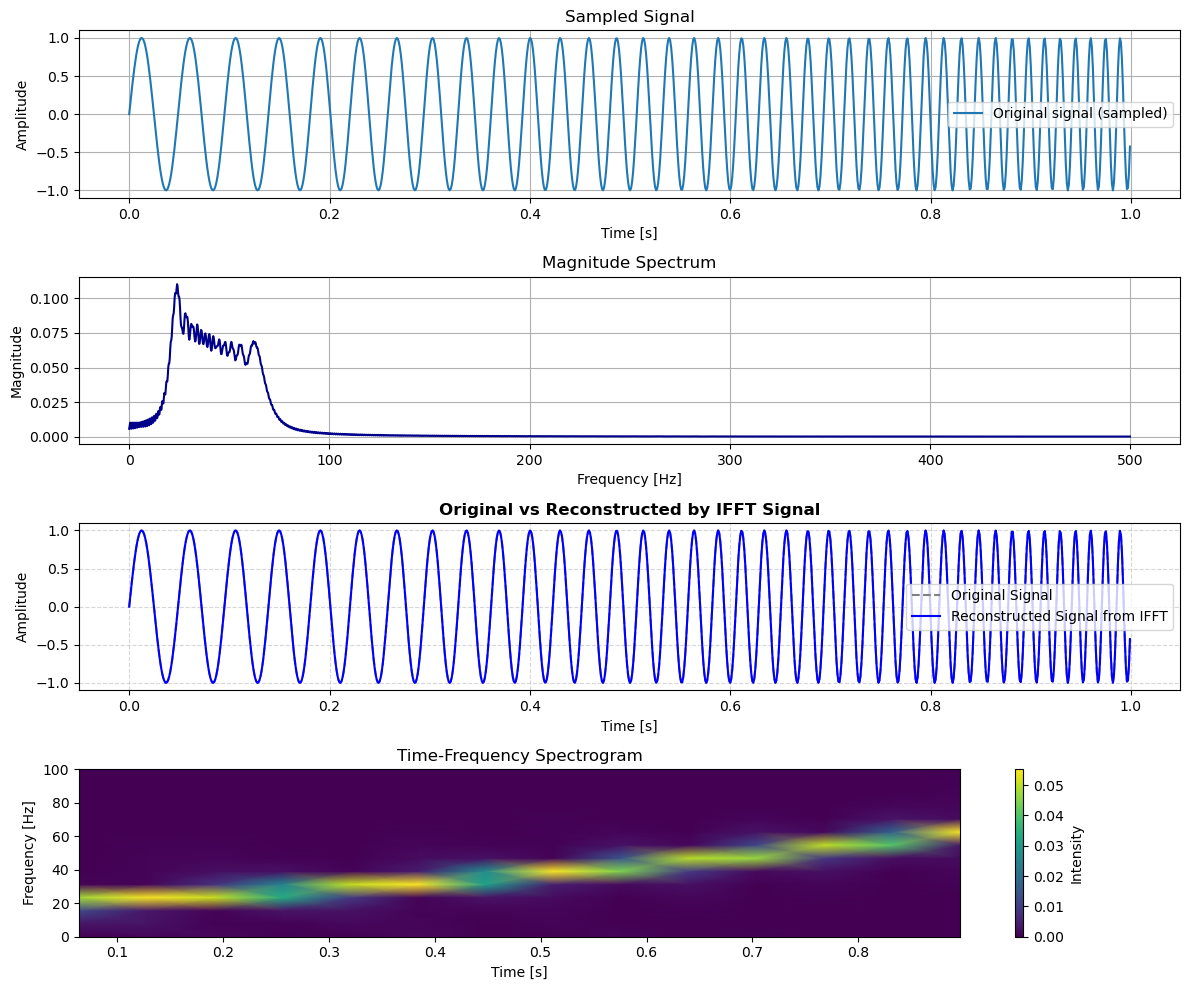

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# 定义 Quadratic Chirp 函数
def func(t, A=1.0, a1=20, a2=10, a3=10):
    return A * np.sin(2 * np.pi * (a1 * t + a2 * t**2 + a3 * t**3))

# 设置 采样参数
fs = 1000  # 采样频率1000Hz
T = 1.0    # 总时长1秒
t = np.arange(0, T, 1/fs)  # 采样时间点

# 定义采样函数
x = func(t)

#傅里叶变换（使用numpy快速进行FFT以及IFFT）
X = np.fft.fft(x)
freqs = np.fft.fftfreq(len(x), d=1/fs)
pos_mask = freqs >= 0
freqs_pos = freqs[pos_mask]
X_pos = X[pos_mask]
x_recon = np.fft.ifft(X).real


# 增强频谱平滑性
n_fft = 4096  # 比原始长度大许多，可以增强频谱插值精度
X = np.fft.fft(x, n=n_fft)
freqs = np.fft.fftfreq(n_fft, d=1/fs)

pos_mask = freqs >= 0
freqs_pos = freqs[pos_mask]
X_pos = X[pos_mask]

#  画图
#图一 生成的函数图像
plt.figure(figsize=(12,10))
plt.subplot(4,1,1)
plt.plot(t, x, label="Original signal (sampled)")
plt.title("Sampled Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()

#频谱图
plt.subplot(4,1,2)
plt.plot(freqs_pos, np.abs(X_pos)/len(x), color='darkblue', linewidth=1.5)
plt.title("Magnitude Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid()

#IFFT作图与原函数图像比较
plt.subplot(4,1,3)
plt.plot(t, x, label="Original Signal", linestyle='--', color='gray')  # 原始信号（虚线）
plt.plot(t, x_recon, label="Reconstructed Signal from IFFT", color='blue')  # 重构信号
plt.title("Original vs Reconstructed by IFFT Signal", fontsize=12, fontweight='bold')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()


# 添加时间频率图
f, t_spec, Sxx = spectrogram(x, fs, nperseg=128, noverlap=64)
plt.subplot(4,1,4)
plt.pcolormesh(t_spec, f, Sxx, shading='gouraud')
plt.title("Time-Frequency Spectrogram")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.ylim(0, 100)
plt.colorbar(label="Intensity")

plt.tight_layout()
plt.show()


使用FIR滤波

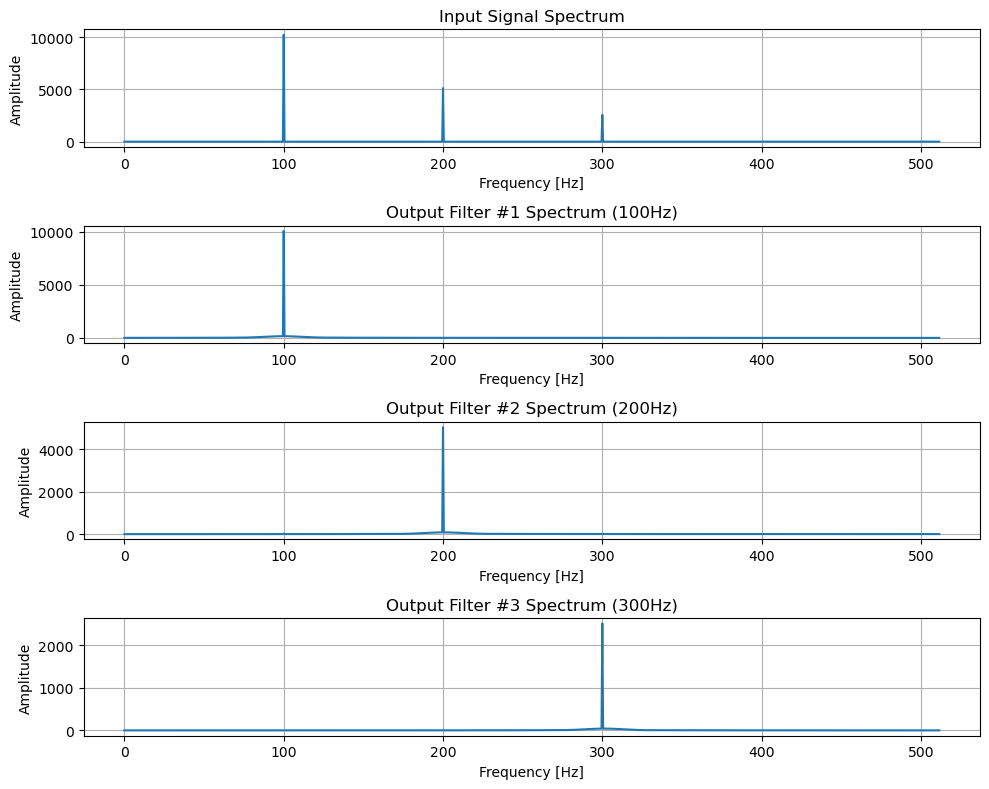

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter

# 定义频谱绘图函数
def plot_spectrum(signal, fs, title):
    N = len(signal)
    f = np.fft.fftfreq(N, d=1/fs)
    f = f[:N//2]  # 只保留正频率部分
    spectrum = np.fft.fft(signal)
    magnitude = np.abs(spectrum[:N//2])

    plt.plot(f, magnitude)
    plt.title(title)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude")
    plt.grid(True)

# 采样参数
fs = 1024
N = 2048
t = np.arange(N) / fs

# 三个不同频率
f1, f2, f3 = 100, 200, 300

# 复合信号
x = 10 * np.sin(2 * np.pi * f1 * t) + 5 * np.sin(2 * np.pi * f2 * t + np.pi / 6) + 2.5 * np.sin(2 * np.pi * f3 * t + np.pi / 4)

# FIR滤波器阶数
order = 64

# 设计带通滤波器（归一化频率为 0~1，1对应 Nyquist）
b1 = firwin(order + 1, [90 / (fs / 2), 110 / (fs / 2)], pass_zero=False)
b2 = firwin(order + 1, [190 / (fs / 2), 210 / (fs / 2)], pass_zero=False)
b3 = firwin(order + 1, [290 / (fs / 2), 310 / (fs / 2)], pass_zero=False)

# 滤波
y1 = lfilter(b1, 1, x)
y2 = lfilter(b2, 1, x)
y3 = lfilter(b3, 1, x)

# 画图
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plot_spectrum(x, fs, "Input Signal Spectrum")

plt.subplot(4, 1, 2)
plot_spectrum(y1, fs, "Output Filter #1 Spectrum (100Hz)")

plt.subplot(4, 1, 3)
plot_spectrum(y2, fs, "Output Filter #2 Spectrum (200Hz)")

plt.subplot(4, 1, 4)
plot_spectrum(y3, fs, "Output Filter #3 Spectrum (300Hz)")

plt.tight_layout()
plt.show()